In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from collections import OrderedDict
from scipy.special import expit
import unittest

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

def run_tests():
  unittest.main(argv=[''], verbosity=1, exit=False)

# Your data

In [0]:
data = OrderedDict(
        amount_spent =  [50,  10, 20, 5,  95,  70,  100,  200, 0],
        send_discount = [0,   1,  1,  1,  0,   0,   0,    0,   1]
    )

In [0]:
df = pd.DataFrame.from_dict(data)
df

,amount_spent,send_discount
0,50,0
1,10,1
2,20,1
3,5,1
4,95,0
5,70,0
6,100,0
7,200,0
8,0,1


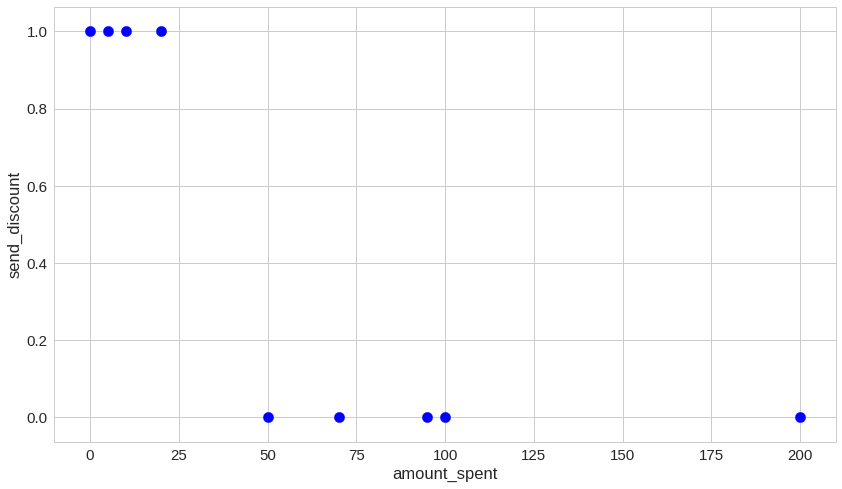

In [0]:
df.plot.scatter(x='amount_spent', y='send_discount', s=108, c="blue");

# Making decisions with Logistic regression

Logistic regression is used for classification problems when the dependant/target variable is binary. That is, its values are true or false. Logistic regression is one of the most popular and widely used algorithms in practice ([see this](https://www.kaggle.com/surveys/2017)).

Some examples for problems that can be solved with Logistic regression are:

- Email - deciding if it is spam or not
- Online transactions - fraudelent or not
- Tumor - malignant or bening
- Customer upgrade - will the customer buy the premium upgrade or not

We want to predict the outcome of a variable $y$, such that:

$$y \in \{0, 1\}$$

and set $0$: negative class (e.g. email is not spam) or $1$: positive class (e.g. email is spam).

## Can't we just use Linear regression?

![](https://www.machinelearningplus.com/wp-content/uploads/2017/09/linear_vs_logistic_regression.jpg)

The response target variable $y$ of the Linear regression model is not restricted within the $[0, 1]$ interval.

# Logistic regression model

Given our problem, we want a model that uses 1 variable (predictor) ($x_1$ - amount_spent) to predict whether or not we should send a discount to the customer.

$$h_w(x) = w_1x_1 + w_0$$

where the coefficients $w_i$ are paramaters of the model. Let the coeffiecient vector $W$ be:

$$
   W =
    \begin{pmatrix}
    w_1 \\
    w_0 \\
    \end{pmatrix}
$$

Then we can represent $h_w(x)$ in more compact form:

$$h_w(x) = w^Tx$$

That is the *Linear regression model*.

We want to build a model that outputs values that are between $0$ and $1$, so we want to come up with a hypothesis that satisfies $0 \leq h_w(x) \leq 1$. For *Logistic regression* we want to modify this and introduce another function $g$:

$$h_w(x) = g(w^Tx)$$

We're going to define $g$ as:

$$g(z) = \frac{1}{1 + e ^{-z}}$$

where $z \in \mathbb{R}$. $g$ is also known as the **sigmoid function** or the **logistic function**. So, after substition, we end up with this definition:

$$h_w(x) = \frac{1}{1 + e ^{-(w^Tx)}}$$

for our hypothesis.

# A closer look at the sigmoid function

Recall that the sigmoid function is defined as:

$$g(z) = \frac{1}{1 + e ^{-z}}$$

where $z \in \mathbb{R}$. Let's translate that to a Python function:

In [0]:
def sigmoid(z):
#   return 1 / (1 + np.exp(-z))
  return expit(z)


In [0]:
class TestSigmoid(unittest.TestCase):

    def test_at_zero(self):
      self.assertAlmostEqual(sigmoid(0), 0.5)
        
    def test_at_negative(self):
      self.assertAlmostEqual(sigmoid(-100), 0)
        
    def test_at_positive(self):
      self.assertAlmostEqual(sigmoid(100), 1)

In [0]:
run_tests()

...
----------------------------------------------------------------------
Ran 3 tests in 0.006s

OK


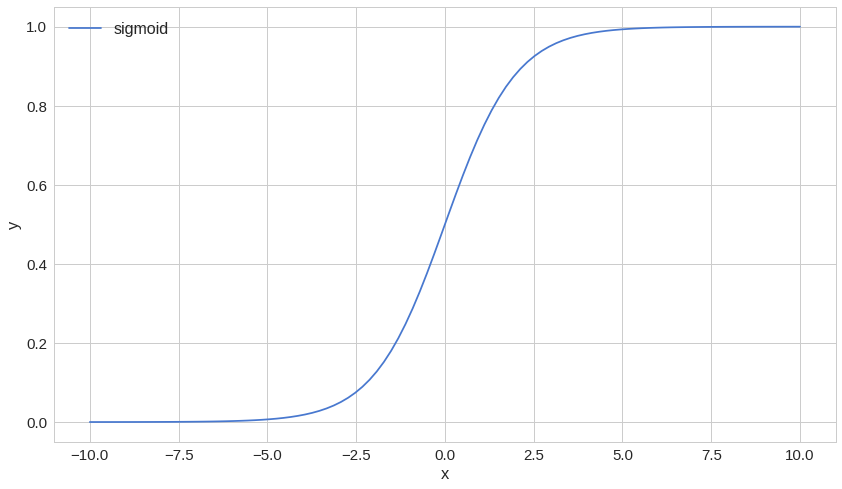

In [0]:
x = np.linspace(-10., 10., num=100)
sig = sigmoid(x)

plt.plot(x, sig, label="sigmoid")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(prop={'size' : 16})
plt.show()

# How can we find the parameters for our model?

Let's examine some approaches to find good parameters for our model. But what does good mean in this context?

## Loss function

We have a model that we can use to make decisions, but we still have to find the parameters $W$. To do that, we need an objective measurement of how good some set of parameters are. For that purpose, we will use a loss (cost) function:

$$J(W) = \frac{1}{m}\sum^m_{i = 1}Cost(h_w(x^{(i)}), y^{(i)})$$

$$
    Cost(h_w(x), y) = 
    \begin{cases} 
    -log(h_w(x)) &\text{if} y = 1\\
    -log(1 - h_w(x)) &\text{if} y = 0
    \end{cases}
$$

Which is also known as the [*Log loss* or *Cross-entropy loss*](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html) function

![](https://ml-cheatsheet.readthedocs.io/en/latest/_images/y1andy2_logistic_function.png)

We can compress the above function into one:

$$J(W) = \frac{1}{m}(-y \log{(h_w)} - (1 - y) \log{(1 - h_w)})$$

where

$$h_w(x) = g(w^Tx)$$

Let's implement it in Python:

In [0]:
def loss(h, y):
  return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()

In [0]:
class TestLoss(unittest.TestCase):

  def test_zero_h_zero_y(self):
    self.assertLess(loss(h=0.000001, y=.000001), 0.0001)

  def test_one_h_zero_y(self):
    self.assertGreater(loss(h=0.9999, y=.000001), 9.0)

  def test_zero_h_one_y(self):
    self.assertGreater(loss(h=0.000001, y=0.9999), 9.0)

  def test_one_h_one_y(self):
    self.assertLess(loss(h=0.999999, y=0.999999), 0.0001)

In [0]:
run_tests()

.......
----------------------------------------------------------------------
Ran 7 tests in 0.010s

OK


## Approach \#1 - I'm thinking of a number(s)

Let's think of 3 numbers that represent the coefficients $w_0, w_1, w_2$.

In [0]:
X = df['amount_spent'].astype('float').values
y = df['send_discount'].astype('float').values

def predict(x, w):
  return sigmoid(x * w)

def print_result(y_hat, y):
  print(f'loss: {np.round(loss(y_hat, y), 5)} predicted: {y_hat} actual: {y}')
  
y_hat = predict(x=X[0], w=.5)
print_result(y_hat, y[0])

loss: 25.0 predicted: 0.999999999986112 actual: 0.0


I am pretty lazy this approach seems like too much hard work for me.

## Approach \#2 - Try out many numbers

Alright, these days computers are pretty fast, 6+ core laptops are everywhere also your phones can are pretty performant, too! Let's use that power for good™ and try to find these parameters by just trying out a lot of numbers:

In [0]:
for w in np.arange(-1, 1, 0.1):
  y_hat = predict(x=X[0], w=w)
  print(loss(y_hat, y[0]))

0.0
0.0
0.0
6.661338147750941e-16
9.359180097590508e-14
1.3887890837434982e-11
2.0611535832696244e-09
3.059022736706331e-07
4.539889921682063e-05
0.006715348489118056
0.6931471805599397
5.006715348489103
10.000045398900186
15.000000305680194
19.999999966169824
24.99999582410784
30.001020555434774
34.945041100449046
inf
inf


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


## Approach \#3 - Gradient descent

Gradient descent algorithms (yes, there are a lot of them) provide us with a way to find a minimum of some function $f$. They work by iteratively going in the direction of the descent as defined by the gradient.

In Machine Learning, we use gradient descent algorithms to find "good" parameters for our models (Logistic Regression, Linear Regression, Neural Networks, etc...).

![](https://i.ytimg.com/vi/b4Vyma9wPHo/maxresdefault.jpg)

**Somewhat deeper look into how Gradient descent works (Source: PyTorchZeroToAll)**

Starting somewhere, we take our first step downhill in the direction specified by the negative gradient. Next, we recalculate the negative gradient and take another step in the direction it specifies. This process continues until we get to a point where we can no longer move downhill - a local minimum.

### First derivative of the sigmoid function

The first derivative of the sigmoid function is given by the following equation:

$$g'(z) = g(z)(1 - g(z))$$

Complete derivation can be found [here](https://math.stackexchange.com/a/1225116/499458).

### First derivative of the cost function

Recall that the cost function was given by the following equation:

$$J(W) = \frac{1}{m}(-y \log{(h_w)} - (1 - y) \log{(1 - h_w)})$$

Given $g'(z) = g(z)(1 - g(z))$

Then:

$$\frac{\partial{J(W)}}{\partial{W}} =\frac{1}{m}(y(1 - h_w) - (1 - y)h_w)x = \frac{1}{m}(y - h_w)x$$

### Updating our parameters $W$

The parameter updating rule we're going to use is defined by:

$$W := W - \alpha (\frac{1}{m}(y - h_w)x)$$

The parameter $\alpha$ is known as **learning rate**. High learning rate can converge quickly, but risks overshooting the lowest point. Low learning rate allows for confident moves in the direction of the negative gradient. However, it time-consuming so it will take us a lot of time to get to converge.

![](https://cdn-images-1.medium.com/max/1600/0*QwE8M4MupSdqA3M4.png)

**Big vs Small learning rate (Source: TowardsDataScoemce)**


### The gradient descent algorithm

```
Repeat until convergence {
  1. Calculate gradient average
  2. Multiply by learning rate
  3. Subtract from weights
}
```

In [0]:
def predict(X, W):
  return sigmoid(np.dot(X, W))
      
def fit(X, y, n_iter=100000, lr=0.01):

  W = np.zeros(X.shape[1])

  for i in range(n_iter):
      z = np.dot(X, W)
      h = sigmoid(z)
      gradient = np.dot(X.T, (h - y)) / y.size
      W -= lr * gradient
  return W

In [0]:
class TestGradientDescent(unittest.TestCase):

    def test_correct_prediction(self):
      global X
      global y
      if len(X.shape) != 2:        
        X = X.reshape(X.shape[0], 1)
      w, _ = fit(X, y)
      y_hat = predict(X, w).round()
      self.assertTrue((y_hat == y).all())

In [0]:
run_tests()

E.......
ERROR: test_correct_prediction (__main__.TestGradientDescent)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-15-59757b6f0a6f>", line 8, in test_correct_prediction
    w, _ = fit(X, y)
ValueError: not enough values to unpack (expected 2, got 1)

----------------------------------------------------------------------
Ran 8 tests in 0.888s

FAILED (errors=1)


Well, that's not good, after all that hustling we're nowhere near achieving our goal of finding good parameters for our model. But, what went wrong? Let's start by finding whether our algorithm improves over time. We can use our loss metric for that:

In [0]:
def fit(X, y, n_iter=100000, lr=0.01):

  W = np.zeros(X.shape[1])
  errors = []
  for i in range(n_iter):
      z = np.dot(X, W)
      h = sigmoid(z)
      gradient = np.dot(X.T, (h - y)) / y.size
      W -= lr * gradient
      
      if(i % 10000 == 0):       
        e = loss(h, y)        
        print(f'loss: {e} \t')
        errors.append(e)
      
  return W, errors

In [0]:
run_tests()

loss: 0.6931471805599453 	
loss: 0.41899283818630056 	
loss: 0.41899283818630056 	
loss: 0.41899283818630056 	
loss: 0.41899283818630056 	
loss: 0.41899283818630056 	
loss: 0.41899283818630056 	
loss: 0.41899283818630056 	
loss: 0.41899283818630056 	


F.......

loss: 0.41899283818630056 	



FAIL: test_correct_prediction (__main__.TestGradientDescent)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-15-59757b6f0a6f>", line 10, in test_correct_prediction
    self.assertTrue((y_hat == y).all())
AssertionError: False is not true

----------------------------------------------------------------------
Ran 8 tests in 0.938s

FAILED (failures=1)


loss: 0.6931471805599453 	
loss: 0.41899283818630056 	
loss: 0.41899283818630056 	
loss: 0.41899283818630056 	
loss: 0.41899283818630056 	
loss: 0.41899283818630056 	
loss: 0.41899283818630056 	
loss: 0.41899283818630056 	
loss: 0.41899283818630056 	
loss: 0.41899283818630056 	


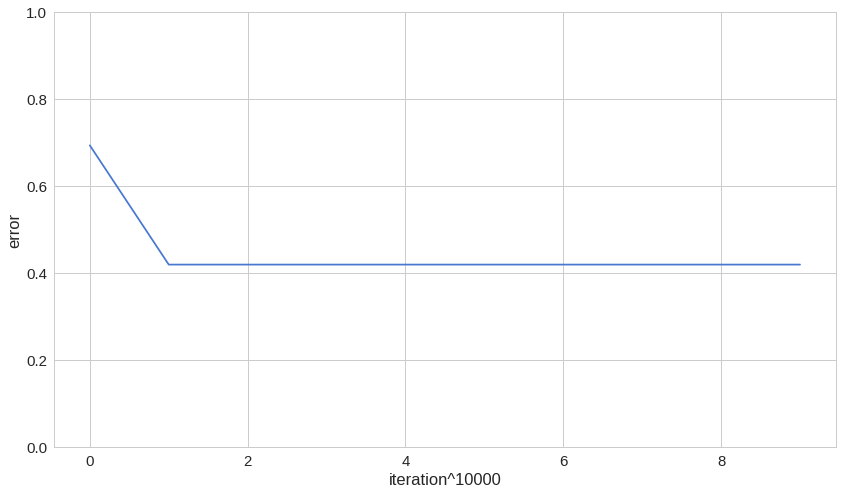

In [0]:
_, errors = fit(X, y)
plt.plot(np.arange(len(errors)), errors)
plt.xlabel("iteration^10000")
plt.ylabel("error")
plt.ylim(0, 1)
plt.show()

Good, we found a possible cause for our problem. Our loss doesn't get low enough, in other words, our algorithm gets stuck at some point that is not a good enough minimum for us. How can we fix this? Perhaps, try out different learning rate or initializing our parameter with a different value?

In [0]:
def fit(X, y, n_iter=100000, lr=0.001):

  W = np.zeros(X.shape[1])
  
  errors = []

  for i in range(n_iter):
      z = np.dot(X, W)
      h = sigmoid(z)
      gradient = np.dot(X.T, (h - y)) / y.size
      W -= lr * gradient
           
      if(i % 10000 == 0):
        e = loss(h, y)
        print(f'loss: {e} \t')
        errors.append(e)
      
  return W, errors

In [0]:
run_tests()

loss: 0.6931471805599453 	
loss: 0.41899283818630056 	
loss: 0.41899283818630056 	
loss: 0.41899283818630056 	
loss: 0.41899283818630056 	
loss: 0.41899283818630056 	
loss: 0.41899283818630056 	
loss: 0.41899283818630056 	
loss: 0.41899283818630056 	


F.......

loss: 0.41899283818630056 	



FAIL: test_correct_prediction (__main__.TestGradientDescent)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-15-59757b6f0a6f>", line 10, in test_correct_prediction
    self.assertTrue((y_hat == y).all())
AssertionError: False is not true

----------------------------------------------------------------------
Ran 8 tests in 0.903s

FAILED (failures=1)


Hmm, how about adding one more parameter for our model to find/learn?

In [0]:
def add_intercept(X):
  intercept = np.ones((X.shape[0], 1))
  return np.concatenate((intercept, X), axis=1)

def predict(X, W):
  X = add_intercept(X)
  return sigmoid(np.dot(X, W))
      
def fit(X, y, n_iter=100000, lr=0.01):
  
  X = add_intercept(X)
  W = np.zeros(X.shape[1])
  
  errors = []

  for i in range(n_iter):
      z = np.dot(X, W)
      h = sigmoid(z)
      gradient = np.dot(X.T, (h - y)) / y.size
      W -= lr * gradient
      
      if(i % 10000 == 0):       
        e = loss(h, y)
        errors.append(e)
  return W, errors

In [0]:
run_tests()

........
----------------------------------------------------------------------
Ran 8 tests in 0.837s

OK


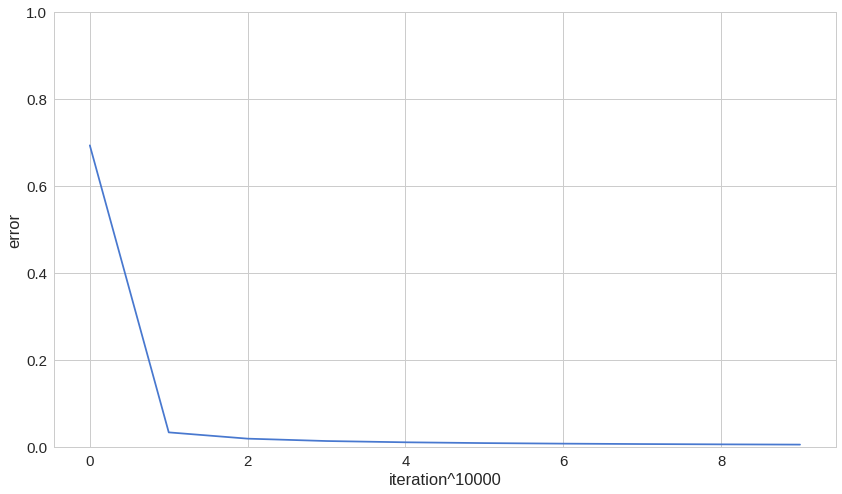

In [0]:
_, errors = fit(X, y)
plt.plot(np.arange(len(errors)), errors)
plt.xlabel("iteration^10000")
plt.ylabel("error")
plt.ylim(0, 1)
plt.show();

### Hiding the complexity of the algorithm

Knowing all of the details of the inner workings of the Gradient descent is good, but when solving problems in the wild, we might be hard pressed for time. In those situations, a simple & easy to use interface for fitting a Logistic Regression model might save us a lot of time. So, let's build one!

But first, let's write some tests:

In [0]:
class TestLogisticRegressor(unittest.TestCase):

    def test_correct_prediction(self):
      global X
      global y
      X = X.reshape(X.shape[0], 1)
      clf = LogisticRegressor()
      y_hat = clf.fit(X, y).predict(X)
      self.assertTrue((y_hat == y).all())

In [0]:
run_tests()

.E.......
ERROR: test_correct_prediction (__main__.TestLogisticRegressor)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-25-b3cbfe737800>", line 7, in test_correct_prediction
    clf = LogisticRegressor()
NameError: name 'LogisticRegressor' is not defined

----------------------------------------------------------------------
Ran 9 tests in 0.858s

FAILED (errors=1)


In [0]:
class LogisticRegressor:
  
  def _add_intercept(self, X):
    intercept = np.ones((X.shape[0], 1))
    return np.concatenate((intercept, X), axis=1)

  def predict_probs(self, X):
    X = self._add_intercept(X)
    return sigmoid(np.dot(X, self.W))
  
  def predict(self, X):
    return self.predict_probs(X).round()
      
  def fit(self, X, y, n_iter=100000, lr=0.01):

    X = self._add_intercept(X)
    self.W = np.zeros(X.shape[1])

    for i in range(n_iter):
        z = np.dot(X, self.W)
        h = sigmoid(z)
        gradient = np.dot(X.T, (h - y)) / y.size
        self.W -= lr * gradient
    return self

In [0]:
run_tests()

.........
----------------------------------------------------------------------
Ran 9 tests in 1.695s

OK


## Using our Regressor to decide who should receive discount codes

Now that you're done with the "hard" part let's use the model to predict whether or not we should send discount codes.

In [0]:
X_test = np.array([10, 250])
X_test = X_test.reshape(X_test.shape[0], 1)
y_test = LogisticRegressor().fit(X, y).predict(X_test)

In [0]:
y_test

array([1., 0.])